In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
from scipy import sparse 
import itertools

import matplotlib.pyplot as plt
import collections
from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.decomposition import PCA
from umap import UMAP

from py_pcha import PCHA

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *
from scroutines import pnmf
from scroutines import basicu



In [2]:
def plot_pcs(res, npc, hue, palette=None):
    fig, axs = plt.subplots(npc-1,npc-1,figsize=(6*(npc-1),5*(npc-1)))
    for i, j in itertools.combinations(range(npc), 2):
        legend = False
        if (i,j) == (0,1): legend=True

        x, y = f"PC{j+1}", f"PC{i+1}"
        ax = axs[i,j-1]
        
        if palette is not None:
            sns.scatterplot(data=res.sample(frac=1, replace=False), 
                            x=x, y=y, 
                            hue=hue,
                            hue_order=list(palette.keys()),
                            palette=palette,
                            s=5, edgecolor='none', 
                            legend=legend,
                            ax=ax,
                           )
        else:
            sns.scatterplot(data=res.sample(frac=1, replace=False), 
                            x=x, y=y, 
                            hue=hue,
                            # hue_order=list(palette.keys()),
                            # palette=palette,
                            s=5, edgecolor='none', 
                            legend=legend,
                            ax=ax,
                           )
        sns.despine(ax=ax)
    axs[0,0].legend(bbox_to_anchor=(0.5, -0.2), loc='upper center')

    for i, j in itertools.product(range(npc-1), range(npc-1)):
        if j<i:
            ax = axs[i,j]
            ax.axis('off')

    plt.show()

In [3]:
outdir     = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results"
outdir_fig = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/figures"

In [4]:
adata_raw = anndata.read("../../data/cheng21_cell_scrna/reorganized/all_IT.h5ad")
adata_raw = adata_raw[adata_raw.obs['Subclass']=='L2/3']
adata_raw = adata_raw[adata_raw.obs['cond'].isin(['P28NR','P28DR'])]
counts = adata_raw.X
allgenes = adata_raw.var.index.values
adata_raw

View of AnnData object with n_obs × n_vars = 8748 × 53801
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond'

In [5]:
# get updated cell types
f = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/allL23_newtypes.csv"
meta = pd.read_csv(f, index_col=0)
meta

/tmp/ipykernel_127824/12491127.py:3: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(f, index_col=0)


,Class_broad,Doublet,Doublet Score,batch,leiden,n_counts,n_genes,percent_mito,sample,Type,Subclass,cond,easitype,umap1,umap2,easisample,easicond,newtype
AAACGCTCACTTCATT-1-P8_1a-P8,Excitatory,False,0.025713,1,0,23384.0,4943,0.000128,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGGATAGGTGCATG-1-P8_1a-P8,Excitatory,False,0.011883,1,0,17774.0,4698,0.000169,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGGGCCAGTATACC-1-P8_1a-P8,Excitatory,False,0.024667,1,0,15872.0,4173,0.000126,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGTCCCATATACCG-1-P8_1a-P8,Excitatory,False,0.027921,1,0,20076.0,4761,0.000050,P8_1a,L2/3_AB,L2/3,P8NR,L2/3_A,NaN,NaN,1a,1-P08NR,L2/3_A
AAAGTCCTCAGATGCT-1-P8_1a-P8,Excitatory,False,0.009527,1,4,19061.0,4601,0.000000,P8_1a,L2/3_BC,L2/3,P8NR,L2/3_C,NaN,NaN,1a,1-P08NR,L2/3_C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCAGTTGTTG-1-P38_dr_1a,NaN,False,0.042872,11,1,11379.0,3568,0.000879,P38_dr_1a,L2/3_3,L2/3,P38DR,L2/3_C,NaN,NaN,1a,2-P38DR,L2/3_B
TTTGGTTTCTGCCTGT-1-P38_dr_2b,NaN,False,0.007108,2,1,16050.0,3104,0.000062,P38_dr_2b,L2/3_3,L2/3,P38DR,L2/3_C,NaN,NaN,2b,2-P38DR,L2/3_B
TTTGTTGCACCGGTCA-1-P38_dr_2a,NaN,False,0.030928,2,1,13955.0,3739,0.001146,P38_dr_2a,L2/3_3,L2/3,P38DR,L2/3_C,NaN,NaN,2a,2-P38DR,L2/3_B
TTTGTTGGTGGCTAGA-1-P38_dr_2b,NaN,False,0.015884,3,4,7272.0,2789,0.000963,P38_dr_2b,L2/3_2,L2/3,P38DR,L2/3_B,NaN,NaN,2b,2-P38DR,L2/3_A


In [6]:
# update new type 
adata_raw.obs['newtype'] = adata_raw.obs['Type'].copy()
adata_raw.obs.update(meta[['newtype']])

/tmp/ipykernel_127824/3478751590.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_raw.obs['newtype'] = adata_raw.obs['Type'].copy()


In [7]:
conds = adata_raw.obs['cond'].values
types = adata_raw.obs['Type'].values
newtypes = adata_raw.obs['newtype'].values
samps = adata_raw.obs['sample'].values

rename_dict = {
    "L2/3_A": "L2/3_A",
    "L2/3_B": "L2/3_B",
    "L2/3_C": "L2/3_C",
    
    "L2/3_1": "L2/3_A",
    "L2/3_2": "L2/3_B",
    "L2/3_3": "L2/3_C",
    
    "L2/3_AB": "L2/3_A",
    "L2/3_BC": "L2/3_C",
}

def rename(x):
    """
    """
    if x in rename_dict.keys():
        return rename_dict[x]
    else:
        return x
    
adata_raw.obs['easitype'] = adata_raw.obs['Type'].apply(rename)

In [8]:
# use those 286 genes
# df = pd.read_csv("../../data/cheng21_cell_scrna/res/candidate_genes_vincent_0503_v2.csv")
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_l23 = df['gene'].values
# genes_sel = adata_raw.var.index.values
# genes_grp = df['P17on'].astype(str).values
# assert len(genes_sel) == len(np.unique(genes_sel))

# Use P28 ordering
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt = pd.read_csv(f)
gpt = gpt['gene_ptime'].values
gptidx = np.argsort(gpt)

In [9]:
# filter genes
cond = np.ravel((adata_raw.X>0).sum(axis=0)) > 10 # expressed in more than 10 cells
adata_sub = adata_raw[:,cond]

# counts
x = adata_sub.X
cov = adata_sub.obs['n_counts'].values
genes = adata_sub.var.index.values

# CP10k
xn = (sparse.diags(1/cov).dot(x))*1e4

# log10(CP10k+1)
xln = xn.copy()
xln.data = np.log10(xln.data+1)

adata_sub.layers['norm'] = xn
adata_sub.layers['lognorm'] = xln

In [10]:
# select HVGs with mean and var
nbin = 20
qth = 0.3

# mean
gm = np.ravel(xn.mean(axis=0))

# var
tmp = xn.copy()
tmp.data = np.power(tmp.data, 2)
gv = np.ravel(tmp.mean(axis=0))-gm**2

# cut 
lbl = pd.qcut(gm, nbin, labels=np.arange(nbin))

# organize
gres = pd.DataFrame()
gres['name'] = genes
gres['lbl'] = lbl
gres['mean'] = gm
gres['var'] = gv
gres['ratio']= gv/gm

# select
gres_sel = gres.groupby('lbl')['ratio'].nlargest(int(qth*(len(gm)/nbin))) #.reset_index()
gsel_idx = np.sort(gres_sel.index.get_level_values(1).values)
assert np.all(gsel_idx != -1)

In [11]:
l23_gidx = basicu.get_index_from_array(genes, genes_l23)
assert np.all(l23_gidx != -1)

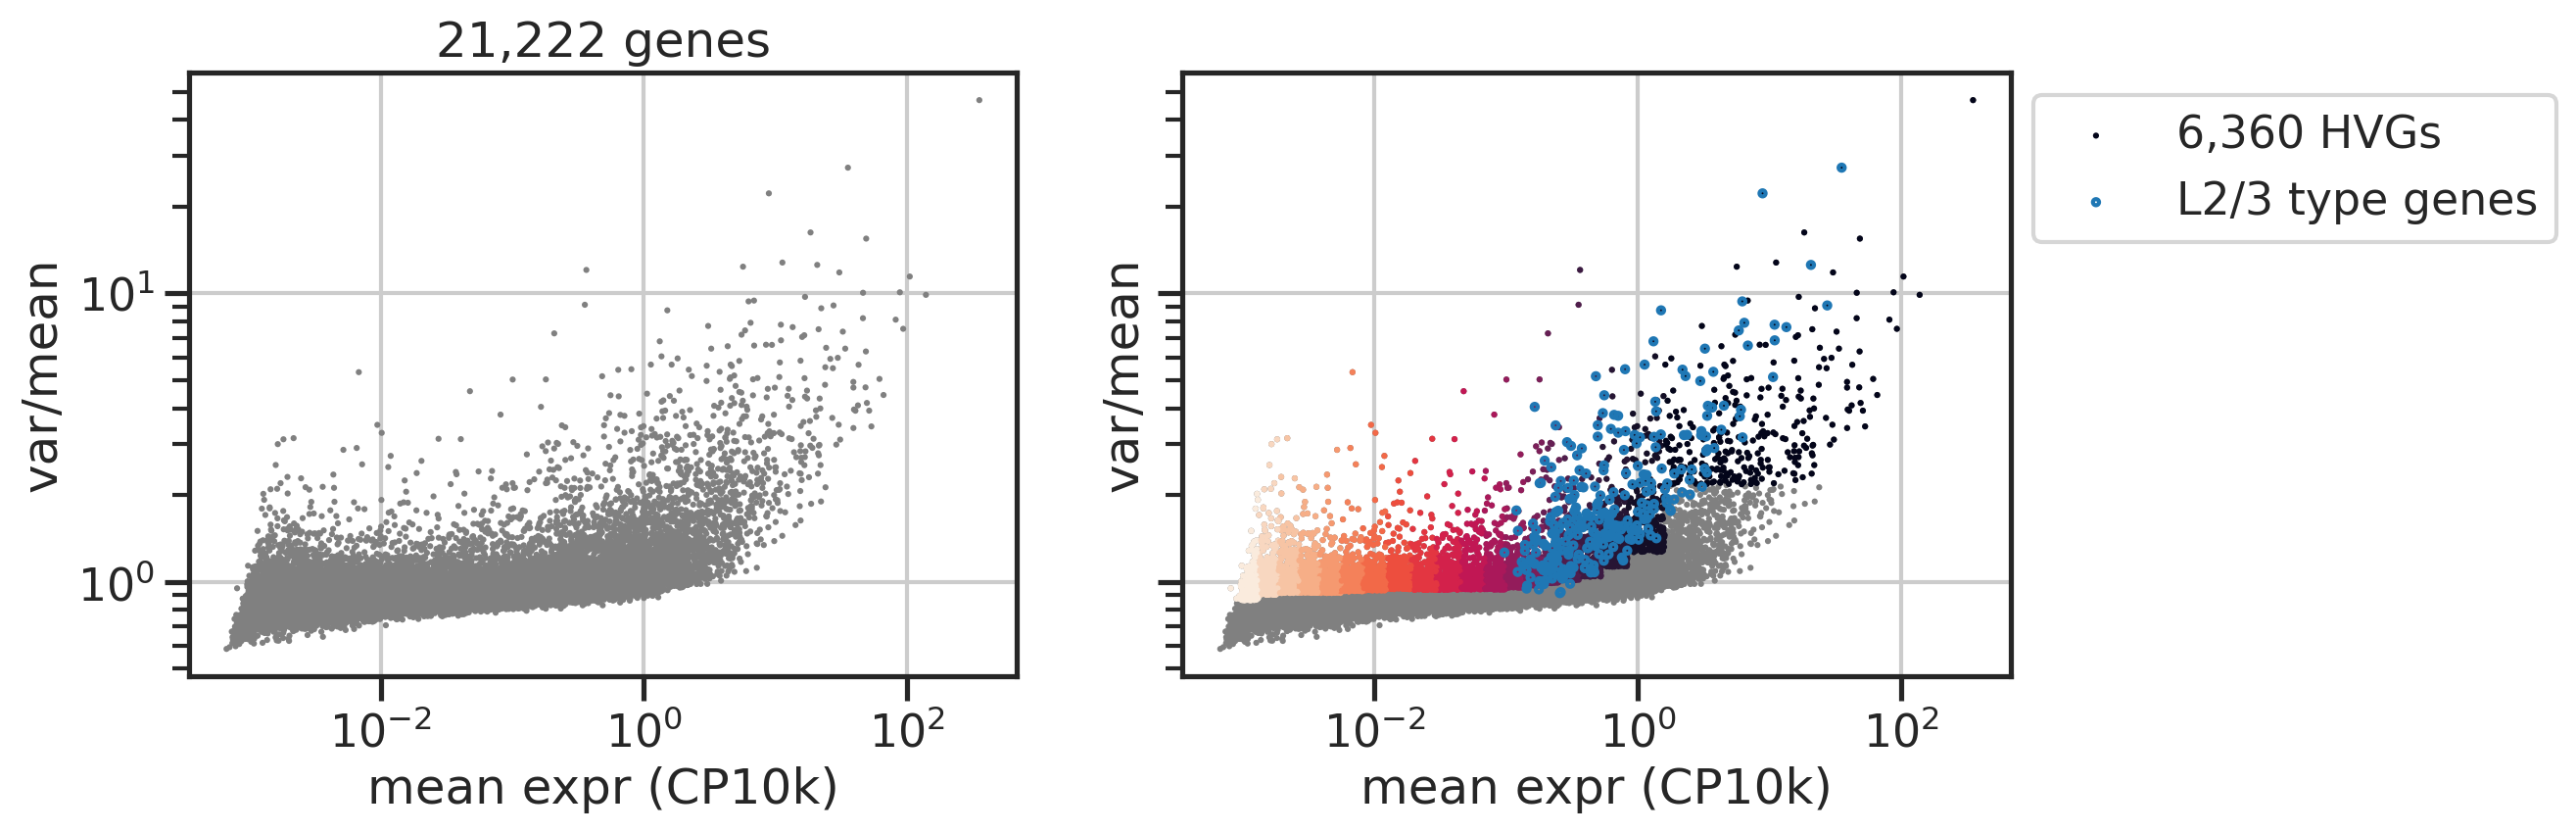

In [12]:
fig, axs = plt.subplots(1,2, figsize=(6*2,4), sharex=True, sharey=True)
ax = axs[0]
ax.scatter(gm, gv/gm, s=5, edgecolor='none', color='gray')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean expr (CP10k)')
ax.set_ylabel('var/mean')
ax.set_title(f'{len(gm):,} genes')

ax = axs[1]
ax.scatter(gm, gv/gm, s=5, edgecolor='none', color='gray')
ax.scatter(gm[gsel_idx], (gv/gm)[gsel_idx], c=lbl[gsel_idx], s=5, edgecolor='none', cmap='rocket_r', label=f'{len(gsel_idx):,} HVGs')
ax.scatter(gm[l23_gidx], (gv/gm)[l23_gidx], s=5, facecolors='none', edgecolor='C0', label='L2/3 type genes')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean expr (CP10k)')
ax.set_ylabel('var/mean')
ax.legend(bbox_to_anchor=(1,1))

plt.show()

In [13]:
adata = adata_sub[:,gsel_idx]
genes_sel = adata.var.index.values
adata

View of AnnData object with n_obs × n_vars = 8748 × 6360
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'newtype', 'easitype'
    layers: 'norm', 'lognorm'

In [14]:
adata_nr = adata[adata.obs['cond']=='P28NR']
# adata_nr1 = adata[adata.obs['sample'].apply(lambda x: x[:-1])=='P28_1']
# adata_nr1a = adata[adata.obs['sample']=='P28_1a']
# adata_nr1b = adata[adata.obs['sample']=='P28_1b']
# adata_nr2 = adata[adata.obs['sample'].apply(lambda x: x[:-1])=='P28_2']

# adata_dr = adata[adata.obs['cond']=='P28DR']
# adata_dr1 = adata[adata.obs['sample'].apply(lambda x: x[:-1])=='P28_dr_1']
# adata_dr2 = adata[adata.obs['sample'].apply(lambda x: x[:-1])=='P28_dr_3']

adata_nr #, adata_dr, adata_nr1, adata_nr2, adata_dr1, adata_dr2

View of AnnData object with n_obs × n_vars = 4044 × 6360
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'newtype', 'easitype'
    layers: 'norm', 'lognorm'

In [15]:
def norm_pca(adata, return_pcs=False):
    
    np.random.seed(0)
    zlognorm = zscore(np.array(adata.layers['lognorm'].todense()), axis=0)
    pca = PCA(n_components=50)
    
    zlognorm = np.nan_to_num(zlognorm, 0)
    pcs = pca.fit_transform(zlognorm)
    if return_pcs:
        return pca, pcs
    else:
        return pca

In [16]:
# vt_nr = norm_pca(adata_nr).components_
# vt_dr = norm_pca(adata_dr).components_

# vt_nr1 = norm_pca(adata_nr1).components_
# vt_nr2 = norm_pca(adata_nr2).components_
# vt_dr1 = norm_pca(adata_dr1).components_
# vt_dr2 = norm_pca(adata_dr2).components_

# vt_nr1a = norm_pca(adata_nr1a).components_
# vt_nr1b = norm_pca(adata_nr1b).components_

In [17]:
pca, pcs = norm_pca(adata_nr, return_pcs=True)

In [18]:
df = adata_nr.obs.join(pd.DataFrame(pcs, index=adata_nr.obs.index, columns=np.char.add("PC", (1+np.arange(pcs.shape[1])).astype(str))))
df

,Class_broad,Doublet,Doublet Score,batch,leiden,n_counts,n_genes,percent_mito,sample,Type,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
AAACCCAGTTCTCTCG-1-P28_1a-P28,Excitatory,False,0.040816,P28,6,16814.0,4895,0.002141,P28_1a,L2/3_C,...,-0.785428,-1.159948,1.775635,1.210071,-1.126263,1.877135,2.754364,0.820827,-0.281765,3.886673
AAACGAAAGCAAGGAA-1-P28_1a-P28,Excitatory,False,0.014196,P28,0,15174.0,4464,0.000132,P28_1a,L2/3_B,...,-2.327219,1.784978,0.491624,0.675891,0.611585,0.274996,2.081093,-0.051451,-0.781091,-0.084043
AAACGCTAGTTTGCTG-1-P28_1a-P28,Excitatory,False,0.071146,P28,6,14503.0,4361,0.000483,P28_1a,L2/3_C,...,0.522656,1.024034,0.670182,0.044185,0.326064,-1.128528,0.058496,0.913236,0.070551,1.799425
AAACGCTCAACCGTGC-1-P28_1a-P28,Excitatory,False,0.102461,P28,6,21649.0,5520,0.000878,P28_1a,L2/3_C,...,-0.689612,0.062632,-0.736605,-0.532487,1.333270,-1.395572,1.241596,-0.768497,0.399549,1.532911
AAAGAACAGCGATGGT-1-P28_1a-P28,Excitatory,False,0.026695,P28,0,5535.0,2633,0.000542,P28_1a,L2/3_B,...,2.005524,4.685754,0.602383,10.575766,5.926121,0.310430,-14.145862,7.441674,-6.671177,0.014422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGATGTAACAAGT-1-P28_2b-P28,Excitatory,False,0.020575,P28,0,12070.0,3374,0.000497,P28_2b,L2/3_B,...,0.286233,-2.708628,0.763873,-0.016192,-2.389452,-0.224503,0.270371,0.228749,1.619671,1.112052
TTTCGATTCCGCTAGG-1-P28_2b-P28,Excitatory,False,0.029584,P28,0,14473.0,4228,0.000345,P28_2b,L2/3_B,...,2.054148,0.405075,-0.087215,-0.061570,-0.978229,-0.310655,-1.049665,2.818481,0.736884,-1.298617
TTTGACTTCAGCTTGA-1-P28_2b-P28,Excitatory,False,0.020575,P28,0,14007.0,4015,0.000928,P28_2b,L2/3_B,...,2.073587,-0.555490,-1.493552,-0.178298,1.243608,-0.060395,1.122425,0.032201,1.120733,1.103004
TTTGATCTCTTTGCTA-1-P28_2b-P28,Excitatory,False,0.031389,P28,0,24911.0,5796,0.000321,P28_2b,L2/3_B,...,1.822482,-0.829676,-0.211831,-0.220758,1.660235,1.122379,1.678042,-0.639643,-0.826100,1.918920


In [19]:
palette_type = collections.OrderedDict({
    "L2/3_A": "C0",
    "L2/3_B": "C1",
    "L2/3_C": "C2",
})
palette_type_list = [c for i, c in palette_type.items()]

<Axes: xlabel='PC1', ylabel='PC2'>

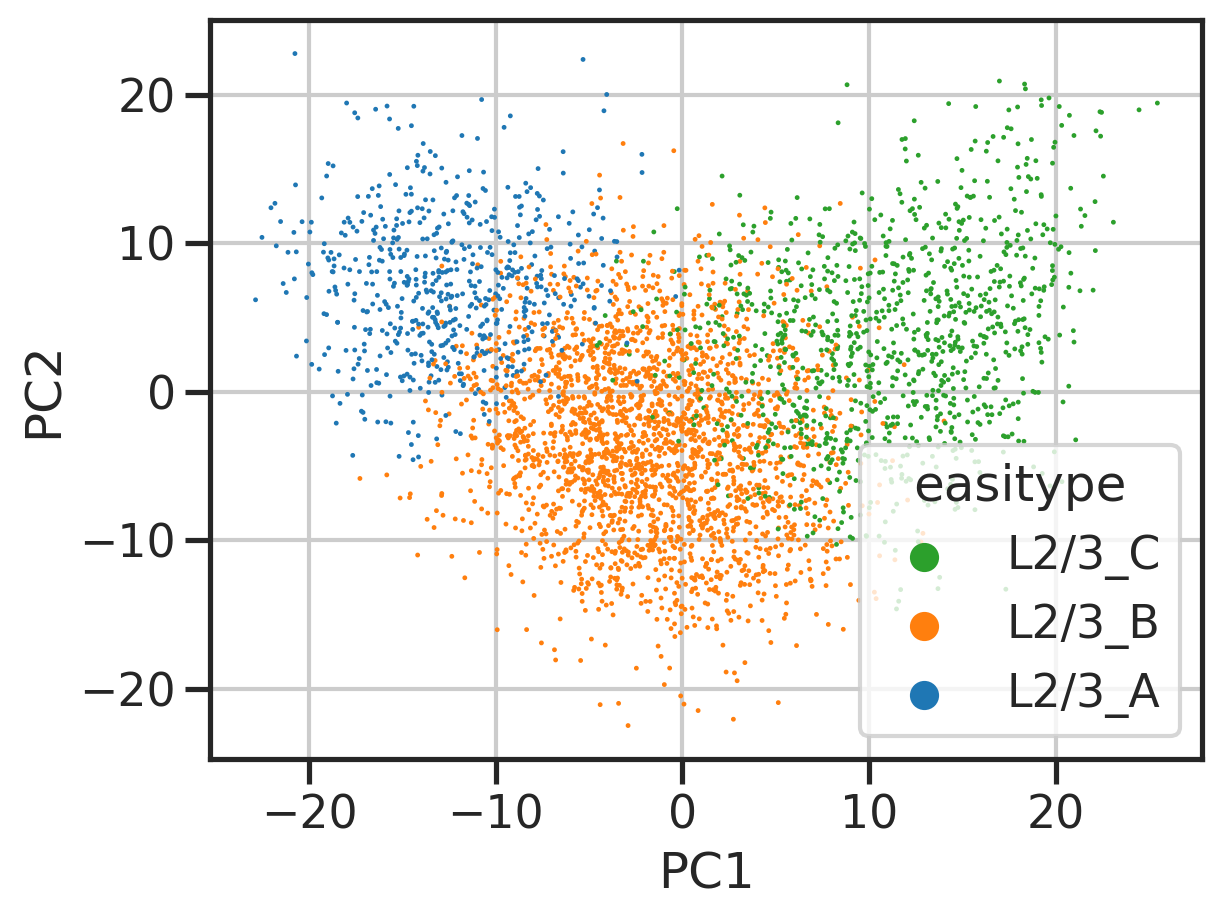

In [20]:
sns.scatterplot(data=df, x='PC1', y='PC2', hue='easitype', s=3, edgecolor='none', palette=palette_type)

In [21]:
X = pcs[:,:2].T
X.shape

(2, 4044)

In [22]:
XC, S, C, SSE, varexpl = PCHA(X, noc=3, delta=0)
XC = np.array(XC)
print(XC.shape, S.shape, C.shape, SSE.shape, varexpl.shape)

(2, 3) (3, 4044) (4044, 3) () ()


In [23]:
SSE, varexpl

(3361.0112131659407, 0.9938749397290596)

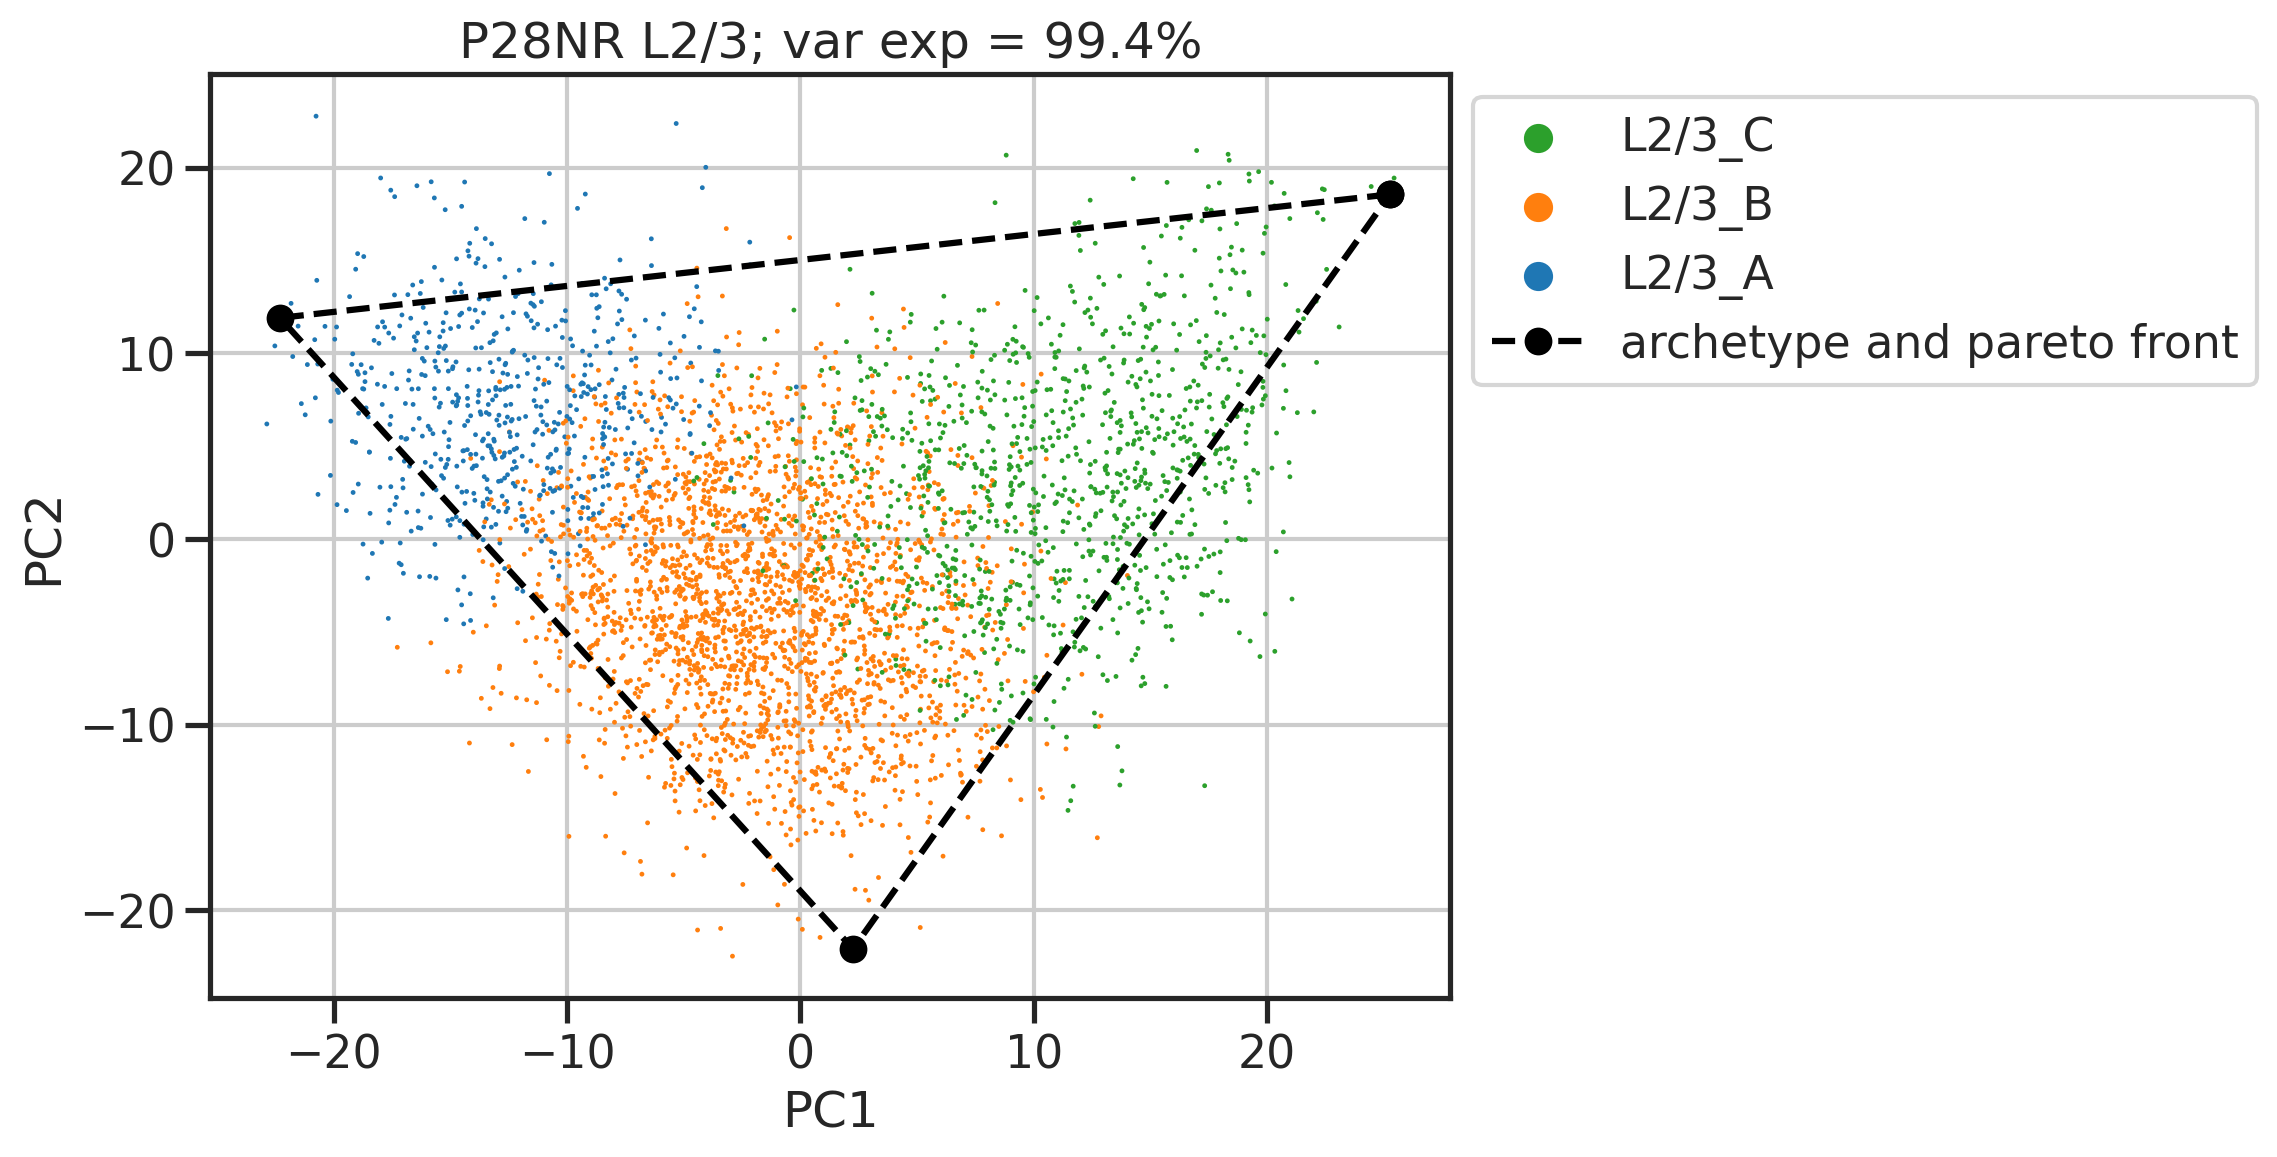

In [24]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='easitype', s=3, palette=palette_type, edgecolor='none', ax=ax)
ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], '--ok', label='archetype and pareto front')
ax.legend(bbox_to_anchor=(1,1))
ax.set_title(f'P28NR L2/3; var exp = {100*varexpl:.1f}%')
plt.show()

# shuffle

In [25]:
adata = adata_nr
zlognorm = zscore(np.array(adata.layers['lognorm'].todense()), axis=0)
zlognorm = np.nan_to_num(zlognorm, 0)

In [26]:
def shuff_genes(mat, seed=0):
    """
    shuffle each column independently
    
    if cell by gene as input; it will shuffle each gene independently across cells
    """
    rng = np.random.default_rng(seed=seed)
    mat_shuff = rng.permuted(mat, axis=0)
    return mat_shuff

# # shuffle each column independently
# rng = np.random.default_rng()
# x = np.arange(24).reshape(3, 8)
# y = rng.permuted(x, axis=0)
# x, y

In [27]:
def get_X(zlognorm):
    """cell by gene as input
    """
    pcs = PCA(n_components=2).fit_transform(zlognorm)
    return pcs.T

In [28]:
def wrap_pcha(X, noc=3, delta=0, **kwargs):
    """
    """
    XC, S, C, SSE, varexpl = PCHA(X, noc=noc, delta=delta, **kwargs)
    return np.array(XC), S, C, SSE, varexpl

In [72]:
def plot_archetype(ax, X, XC, varexpl, c=None):
    """
    """
    ax.scatter(X[0], X[1], c=c, s=2)
    ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], '--ok', 
            label=f'archetype\nvar expl = {100*varexpl:.1f}%')
    return ax 

def plot_archetype_only(ax, XC, fmt='--o', color='k', **kwargs):
    """
    """
    ax.plot(XC[0].tolist()+[XC[0,0]], XC[1].tolist()+[XC[1,0]], fmt, color=color, **kwargs)

In [58]:
def downsample_X(X, p=0.8):
    """
    """
    return X[:,np.random.rand(X.shape[1])<p]

In [30]:
# cell by gene
print(zlognorm.shape)

(4044, 6360)


In [31]:
types = adata_nr.obs['easitype']
type_colorvec = pd.Series(palette_type).reindex(types).values

In [32]:
# orig
X = get_X(zlognorm)
XC, S, C, SSE, varexpl = wrap_pcha(X, noc=3, delta=0)

In [74]:
nrepeats = 10

In [75]:
res_XC_sub = []
for i in range(nrepeats):
    X_sub = downsample_X(X, p=0.8)
    XC_sub, _, _, _, _ = wrap_pcha(X_sub, noc=3, delta=0)
    res_XC_sub.append(XC_sub)

In [76]:
# shuff each gene across cells independently
zlognorm_shuff = shuff_genes(zlognorm)
X_shuff = get_X(zlognorm_shuff)
XC_shuff, S_shuff, C_shuff, SSE_shuff, varexpl_shuff = wrap_pcha(X_shuff, noc=3, delta=0)

In [77]:
res_XC_shuff_sub = []
for i in range(nrepeats):
    X_shuff_sub = downsample_X(X_shuff, p=0.8)
    XC_shuff, _, _, _, _ = wrap_pcha(X_shuff_sub, noc=3, delta=0)
    res_XC_shuff_sub.append(XC_shuff)

In [78]:
# shuff each gene across cells independently - internally for each type A,B,C
zlognorm_tshuff = zlognorm.copy()
idx, lbl = pd.factorize(types)
for i in range(len(lbl)):
    zlognorm_tshuff[idx==i] = shuff_genes(zlognorm[idx==i])

X_tshuff = get_X(zlognorm_tshuff)
XC_tshuff, S_tshuff, C_tshuff, SSE_tshuff, varexpl_tshuff = wrap_pcha(X_tshuff, noc=3, delta=0)

In [79]:
res_XC_tshuff_sub = []
for i in range(nrepeats):
    X_tshuff_sub = downsample_X(X_tshuff, p=0.8)
    XC_tshuff, _, _, _, _ = wrap_pcha(X_tshuff_sub, noc=3, delta=0)
    res_XC_tshuff_sub.append(XC_tshuff)

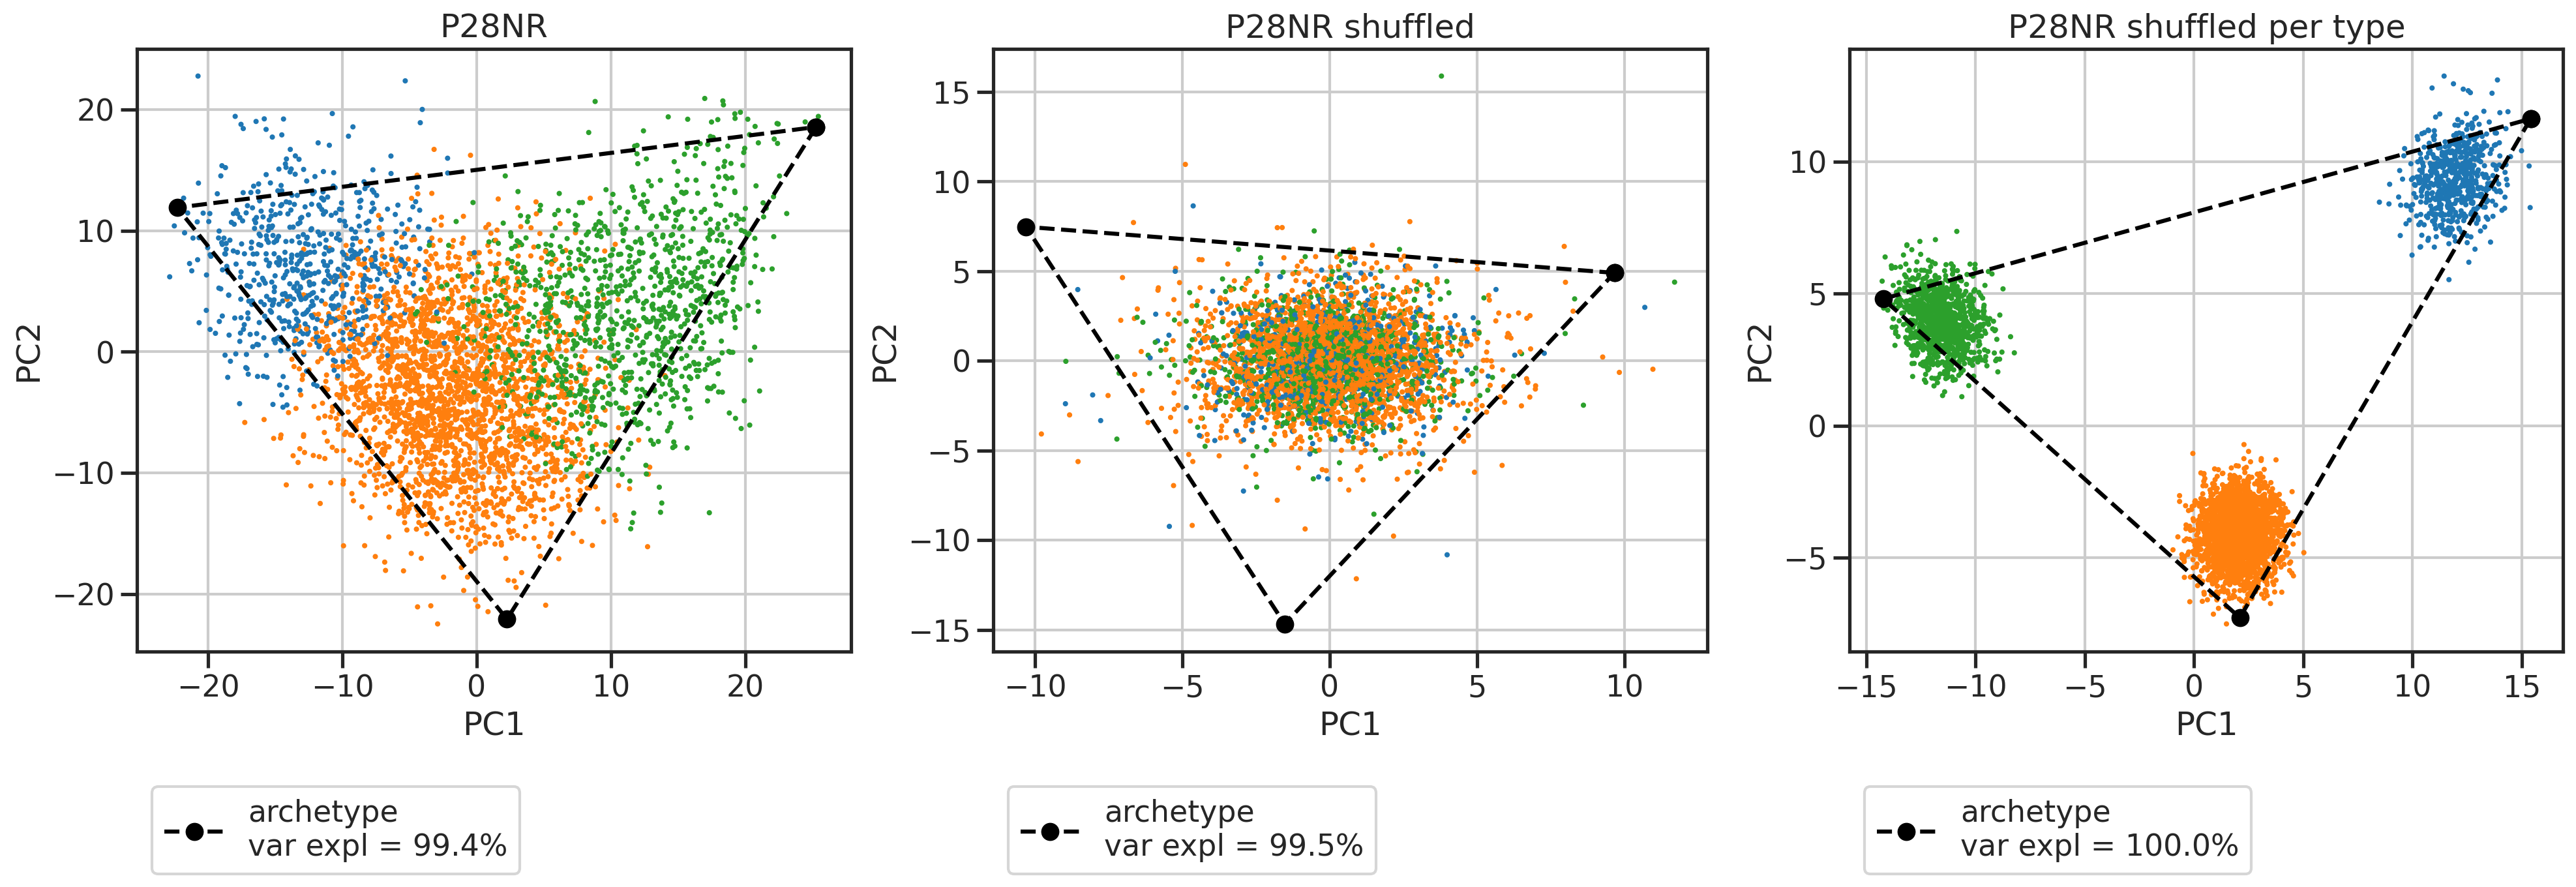

In [82]:
fig, axs = plt.subplots(1,3,figsize=(8*3,6))
ax = axs[0]
plot_archetype(ax, X, XC, varexpl, c=type_colorvec)
ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('P28NR')

ax = axs[1]
plot_archetype(ax, X_shuff, XC_shuff, varexpl_shuff, c=type_colorvec)
ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('P28NR shuffled')

ax = axs[2]
plot_archetype(ax, X_tshuff, XC_tshuff, varexpl_tshuff, c=type_colorvec)
ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('P28NR shuffled per type')
plt.show()

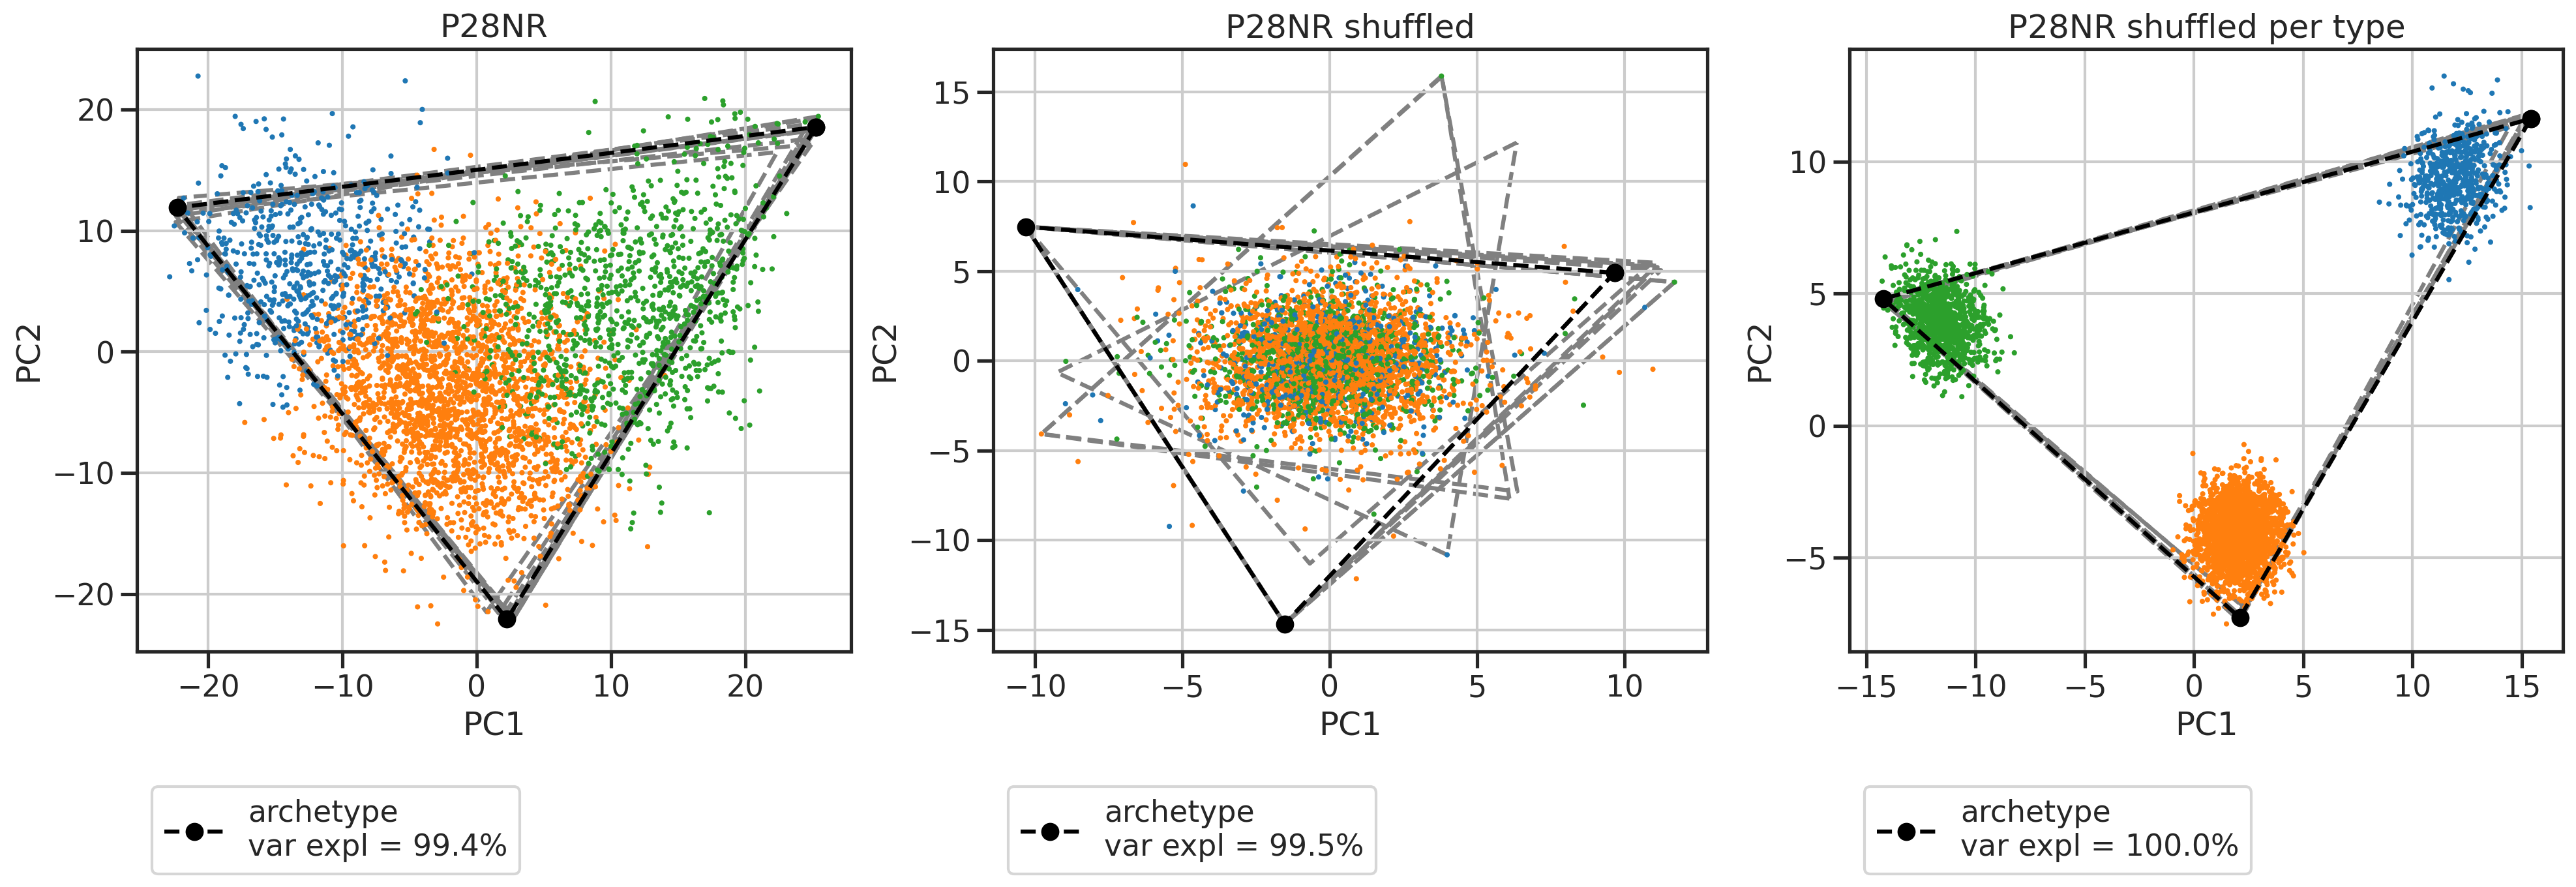

In [81]:
fig, axs = plt.subplots(1,3,figsize=(8*3,6))
ax = axs[0]
plot_archetype(ax, X, XC, varexpl, c=type_colorvec)
for i in range(nrepeats):
    plot_archetype_only(ax, res_XC_sub[i], 
                        fmt='--', color='gray', zorder=0)
ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('P28NR')

ax = axs[1]
plot_archetype(ax, X_shuff, XC_shuff, varexpl_shuff, c=type_colorvec)
for i in range(nrepeats):
    plot_archetype_only(ax, res_XC_shuff_sub[i], 
                        fmt='--', color='gray', zorder=0)
ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('P28NR shuffled')

ax = axs[2]
plot_archetype(ax, X_tshuff, XC_tshuff, varexpl_tshuff, c=type_colorvec)
for i in range(nrepeats):
    plot_archetype_only(ax, res_XC_tshuff_sub[i], 
                        fmt='--', color='gray', zorder=0)
ax.legend(bbox_to_anchor=(0,-0.2), loc='upper left')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('P28NR shuffled per type')
plt.show()

# measure t-ratio

In [37]:
from scipy.spatial import ConvexHull

def get_poly_area(xy):
    x = xy[:,0]
    y = xy[:,1]
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def get_convex_hull_area(X):
    a = ConvexHull(X.T)
    
    # same result
    # xy = a.points[a.vertices]
    # get_poly_area(xy)
    
    return a.volume


In [38]:
ch_area = get_convex_hull_area(X)
pch_area = get_poly_area(XC.T)

ch_area_shuff = get_convex_hull_area(X_shuff)
pch_area_shuff = get_poly_area(XC_shuff.T)

In [39]:
ch_area, pch_area, pch_area/ch_area

(1635.8160290881442, 890.9581116932336, 0.5446566703407851)

In [40]:
ch_area_shuff, pch_area_shuff, pch_area_shuff/ch_area_shuff

(356.6575122973285, 178.2864177013933, 0.49988129102623347)

In [41]:
pch_area / ch_area

0.5446566703407851